# IOOS Access 03: Accessing IOOS and OOI glider data from the IOOS Glider DAC via ERDDAP and erddapy

ERDDAP has RESTful API that is very convenient for creating web apps, data portals, etc. However, writing those URLs manually can be tedious and error prone

This notebook walks through an easy to set up ERDDAP RESTful URL by using the python client, `erddapy`, https://pyoceans.github.io/erddapy/

A typical ERDDAP RESTful URL looks like:

[https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z &latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0](https://data.ioos.us/gliders/erddap/tabledap/whoi_406-20160902T1700.mat?depth,latitude,longitude,salinity,temperature,time&time>=2016-07-10T00:00:00Z&time<=2017-02-10T00:00:00Z&latitude>=38.0&latitude<=41.0&longitude>=-72.0&longitude<=-69.0)

Let's break it down to smaller parts:

- **server**: https://data.ioos.us/gliders/erddap/
- **protocol**: tabledap
- **dataset_id**: whoi_406-20160902T1700
- **response**: .mat
- **variables**: depth,latitude,longitude,temperature,time
- **constraints**:
    - time>=2016-07-10T00:00:00Z
    - time<=2017-02-10T00:00:00Z
    - latitude>=38.0
    - latitude<=41.0
    - longitude>=-72.0
    - longitude<=-69.0

### Emilio's notes, 7/24
- The original notebook from the IOOS gallery is at http://ioos.github.io/notebooks_demos/notebooks/2018-03-01-erddapy/
- A newer version of the notebook is presented at https://pyoceans.github.io/erddapy/quick_intro.html, and even newer at this gist Filipe created on 7/23: http://nbviewer.jupyter.org/gist/ocefpaf/2e45fe0bdd0320496aa3b7f98f07a4d9
- Ask Filipe about why there are two types (parameters) of lat-lon and temporal constraints
- Ask Filipe about the initial dataset search with "min" parameters, how that reflects a "within" vs "contains" query vis a vis CSW queries

## Preamble

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import folium

import pandas as pd
import geopandas as gpd
import shapely.geometry as shpgeom

from erddapy import ERDDAP

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
server = 'https://data.ioos.us/gliders/erddap'
protocol = 'tabledap'

Specify the **Endurance Array geographical bounding box**, then read into a `Shapely` geometry (polygon) and a `GeoPandas` GeoSeries for convenience and reuse.

In [3]:
min_lon, max_lon = -127, -123.75
min_lat, max_lat = 43, 48

endurance_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
endurance_bbox_gs = gpd.GeoSeries(endurance_bbox_shp)

Feeding these variables in the `erddapy.ERDDAP` class we will create the URL builder object.

## 1. Search ERDDAP "catalog"

In [4]:
e = ERDDAP(server=server, protocol=protocol)

In [5]:
df = pd.read_csv(e.get_search_url(response='csv', search_for='all'))
len(df)

472

We can refine our search by adding some constraints.

In [6]:
min_time = '2015-01-01T00:00:00Z'
max_time = '2016-12-31T00:00:00Z'

# why is it using these min/max parameter names, instead of the parameter (key) names that include >, >=, etc??
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectoryprofile' #is this actually helpful here, or clutter?
}

In [7]:
search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)

gliders = search['Dataset ID'].values

msg = 'Found {} Glider Datasets:\n\n{}'.format
print(msg(len(gliders), '\n'.join(gliders)))

Found 30 Glider Datasets:

allnanoos-uwGliders
ce_247-20160510T0242
ce_247-20160928T2157
ce_311-20160122T2045
ce_311-20161011T2101
ce_312-20160122T2140
ce_312-20160920T1743
ce_319-20151008T2255
ce_319-20160616T1912
ce_320-20160616T2004
ce_326-20150410T1942
ce_326-20151015T1908
ce_326-20160217T1655
ce_327-20150603T0000
ce_327-20151015T1701
ce_327-20160923T0147
ce_327-20161215T2058
ce_382-20150121T2202
ce_382-20160928T2102
ce_383-20150121T2028
ce_383-20150813T2109
ce_384-20150411T1807
ce_384-20160507T1655
ce_386-20150404T1729
ce_386-20151015T2247
ce_386-20160922T2355
ce_386-20161215T1736
SG187-20140625T1330
SG187-20150616T1034
UW157-20141116T2118


In [8]:
# A simple value_counts() is less readable. So, display as DataFrame
pd.DataFrame(search.Institution.value_counts()).head()

,Institution
Ocean Observatories Initiative,26
"Applied Physics Lab\nUniversity of Washington\nSeattle, WA",3
"Oregon State University\nCollege of Earth, Ocean and Atmospheric Sciences\n104 CEOAS Admin Bldg\nCorvallis, OR 97331-5503",1


26 OOI datasets and 4 (3 UW-led + 1 OSU-led) NANOOS datasets.

In [9]:
search.head()

,griddap,Subset,tabledap,Make A Graph,wms,files,Title,Summary,FGDC,ISO 19115,Info,Background Info,RSS,Email,Institution,Dataset ID
0,NaN,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,https://data.ioos.us/gliders/erddap/tabledap/a...,NaN,NaN,All nanoos-uw Gliders,"Seaglider La Push NANOOS line, Washington. Gli...",https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/allna...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/allnan...,https://data.ioos.us/gliders/erddap/subscripti...,Applied Physics Lab\nUniversity of Washington\...,allnanoos-uwGliders
1,NaN,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,NaN,NaN,ce_247-20160510T0242,The Endurance Array is a multi-scaled array ut...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/ce_24...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/ce_247...,https://data.ioos.us/gliders/erddap/subscripti...,Ocean Observatories Initiative,ce_247-20160510T0242
2,NaN,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,NaN,NaN,ce_247-20160928T2157,The Endurance Array is a multi-scaled array ut...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/ce_24...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/ce_247...,https://data.ioos.us/gliders/erddap/subscripti...,Ocean Observatories Initiative,ce_247-20160928T2157
3,NaN,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,NaN,NaN,ce_311-20160122T2045,The Endurance Array is a multi-scaled array ut...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/ce_31...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/ce_311...,https://data.ioos.us/gliders/erddap/subscripti...,Ocean Observatories Initiative,ce_311-20160122T2045
4,NaN,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,https://data.ioos.us/gliders/erddap/tabledap/c...,NaN,NaN,ce_311-20161011T2101,The Endurance Array is a multi-scaled array ut...,https://data.ioos.us/gliders/erddap/metadata/f...,https://data.ioos.us/gliders/erddap/metadata/i...,https://data.ioos.us/gliders/erddap/info/ce_31...,http://data.ioos.us/gliders/erddap/,https://data.ioos.us/gliders/erddap/rss/ce_311...,https://data.ioos.us/gliders/erddap/subscripti...,Ocean Observatories Initiative,ce_311-20161011T2101


For futher, efficient use, remove from the `gliders` list datasets with names (`Dataset ID`) starting with "all" (here, `allnanoos-uwGliders`), because it's redundant and will make data downloads slower.

In [10]:
gliders = [datasetid for datasetid in gliders if not datasetid.startswith('all')]

## 2. Investigate one glider dataset, picked manually
Let's inspect a specific `dataset_id`.

In [11]:
dataset_id = 'ce_327-20160923T0147'

### Investigate metadata for one dataset

In [12]:
info_url = e.get_info_url(dataset_id=dataset_id, response='csv')
info = pd.read_csv(info_url)

In [13]:
# Lots of metadata available
len(info)

591

In [14]:
info.head(20)

,Row Type,Variable Name,Attribute Name,Data Type,Value
0,attribute,NC_GLOBAL,acknowledgment,String,Funding provided by the National Science Found...
1,attribute,NC_GLOBAL,cdm_data_type,String,TrajectoryProfile
2,attribute,NC_GLOBAL,cdm_profile_variables,String,"profile_id, time, latitude, longitude, time_uv..."
3,attribute,NC_GLOBAL,cdm_trajectory_variables,String,"trajectory, wmo_id"
4,attribute,NC_GLOBAL,contributor_name,String,"Ed Dever,Jon Fram,Stuart Pearce,John Kerfoot"
5,attribute,NC_GLOBAL,contributor_role,String,"Endurance Array Program Manager,Endurance Arra..."
6,attribute,NC_GLOBAL,Conventions,String,"Unidata Dataset Discovery v1.0, COARDS, CF-1.6"
7,attribute,NC_GLOBAL,creator_email,String,kerfoot@marine.rutgers.edu
8,attribute,NC_GLOBAL,creator_name,String,John Kerfoot
9,attribute,NC_GLOBAL,creator_url,String,http://www.whoi.edu/ooi_cgsn/home


In [15]:
info.groupby(['Variable Name', 'Row Type']).size()

Variable Name    Row Type 
NC_GLOBAL        attribute    59
conductivity     attribute    17
                 variable      1
conductivity_qc  attribute    11
                 variable      1
density          attribute    17
                 variable      1
density_qc       attribute    11
                 variable      1
depth            attribute    22
                 variable      1
depth_qc         attribute    11
                 variable      1
instrument_ctd   attribute     9
                 variable      1
lat_uv           attribute    14
                 variable      1
lat_uv_qc        attribute    10
                 variable      1
latitude         attribute    17
                 variable      1
latitude_qc      attribute    10
                 variable      1
lon_uv           attribute    14
                 variable      1
lon_uv_qc        attribute    10
                 variable      1
longitude        attribute    17
                 variable      1
longitude_qc    

With the info URL we can filter the data using attributes.

In [16]:
cdm_profile_variables = info.loc[
    info['Attribute Name'] == 'cdm_profile_variables', 'Variable Name'
]

print(''.join(cdm_profile_variables))

NC_GLOBAL


In fact, that is such a common operation that `erddapy` brings its own method for filtering data by attributes. In the next three cells we request the variables names that has a `cdm_profile_variables`, a `standard_name` of `sea_water_temperature`, and an axis respectively.

In [17]:
e.get_var_by_attr(
    dataset_id=dataset_id,
    cdm_profile_variables=lambda v: v is not None,
)

['NC_GLOBAL']

In [18]:
# e.get_var_by_attr(
#     dataset_id='whoi_406-20160902T1700',
#     standard_name='sea_water_temperature',
# )

In [19]:
e.get_var_by_attr(
    dataset_id=dataset_id,
    axis=lambda v: v in ['X', 'Y', 'Z', 'T'],
)

['time',
 'precise_lon',
 'precise_lat',
 'depth',
 'pressure',
 'precise_time',
 'latitude',
 'longitude']

### Read and transform the data

NOTE: setting a dataset_id filter makes the time and spatial filters mostly redundant. I've removed the spatial constraints, and can probably remove the temporal ones too.

In [20]:
variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

# No spatial or temporal constraints, because we're pulling in the entire dataset

Reuse `e`

In [21]:
e.dataset_id = dataset_id
e.variables = variables

This is just a sample of forming a url to request a mat file

In [22]:
url = e.get_download_url(response='mat')

print(url)

https://data.ioos.us/gliders/erddap/tabledap/ce_327-20160923T0147.mat?depth,latitude,longitude,salinity,temperature,time


Additionally, the object has `.get_info_url()` and `.get_search_url()` that can be used to obtain the info and search URLs respectively

`erddapy` also provides some simple methods to download the data transformed into common Python data structures, like `pandas.DataFrame` and `xarray.Dataset`.

In [23]:
df = e.to_pandas(
    index_col='time',
    parse_dates=True,
    skiprows=(1,)  # drop the units row (second header row)
).dropna()

df.head()

,depth,latitude,longitude,salinity,temperature
time,,,,,
2016-09-23 02:53:59,6.029532,46.844764,-124.970629,32.036080,16.1662
2016-09-23 02:53:59,17.721159,46.844764,-124.970629,32.065550,15.8635
2016-09-23 02:53:59,29.084904,46.844764,-124.970629,32.625830,12.2676
2016-09-23 02:53:59,39.337505,46.844764,-124.970629,32.647892,10.8881
2016-09-23 02:53:59,49.123608,46.844764,-124.970629,32.663166,10.1780


Reading into `xarray` has the advantage of bringing much richer metadata (at the level of both the dataset and variables) which `pandas` data frames don't readily support. This may come at the cost of the somewhat more complex data structures if you're not used to netCDF.

In [24]:
ds = e.to_xarray(decode_times=True)

In [25]:
ds

<xarray.Dataset>
Dimensions:      (row: 18694)
Coordinates:
    depth        (row) float32 ...
    latitude     (row) float64 ...
    longitude    (row) float64 ...
    time         (row) datetime64[ns] ...
Dimensions without coordinates: row
Data variables:
    salinity     (row) float32 ...
    temperature  (row) float32 ...
Attributes:
    acknowledgment:                Funding provided by the National Science F...
    cdm_data_type:                 TrajectoryProfile
    cdm_profile_variables:         profile_id, time, latitude, longitude, tim...
    cdm_trajectory_variables:      trajectory, wmo_id
    contributor_name:              Ed Dever,Jon Fram,Stuart Pearce,John Kerfoot
    contributor_role:              Endurance Array Program Manager,Endurance ...
    Conventions:                   Unidata Dataset Discovery v1.0, COARDS, CF...
    creator_email:                 kerfoot@marine.rutgers.edu
    creator_name:                  John Kerfoot
    creator_url:                   htt

In [26]:
ds['temperature']

<xarray.DataArray 'temperature' (row: 18694)>
array([16.1662, 15.8635, 12.2676, ..., 12.1134, 11.623 , 10.498 ],
      dtype=float32)
Coordinates:
    depth      (row) float32 ...
    latitude   (row) float64 ...
    longitude  (row) float64 ...
    time       (row) datetime64[ns] ...
Dimensions without coordinates: row
Attributes:
    _ChunkSizes:          1
    actual_range:         [ 0.     17.3803]
    ancillary_variables:  temperature_qc
    colorBarMaximum:      32.0
    colorBarMinimum:      0.0
    instrument:           instrument_ctd
    ioos_category:        Temperature
    long_name:            Sea Water Temperature
    observation_type:     measured
    platform:             platform
    source_variable:      sci_water_temp
    standard_name:        sea_water_temperature
    units:                degree_Celsius
    valid_max:            40.0
    valid_min:            -5.0

Here is a simple scatter plot using the data from `xarray` dataset (ds).

In [27]:
temperature_df = ds['temperature'].to_dataframe()
temperature_df.set_index('time', inplace=True)
temperature_df.head()

,depth,latitude,longitude,temperature
time,,,,
2016-09-23 02:53:59.003750144,6.029532,46.844764,-124.970629,16.166201
2016-09-23 02:53:59.003750144,17.721159,46.844764,-124.970629,15.863500
2016-09-23 02:53:59.003750144,29.084904,46.844764,-124.970629,12.267600
2016-09-23 02:53:59.003750144,39.337505,46.844764,-124.970629,10.888100
2016-09-23 02:53:59.003750144,49.123608,46.844764,-124.970629,10.178000


### Create a section plot of the temperature data (depth vs time)
Plot using a matplotlib scatter plot with colored dots. Label axes and colorbar using variable attributes extracted directly from the `xarray` dataset.

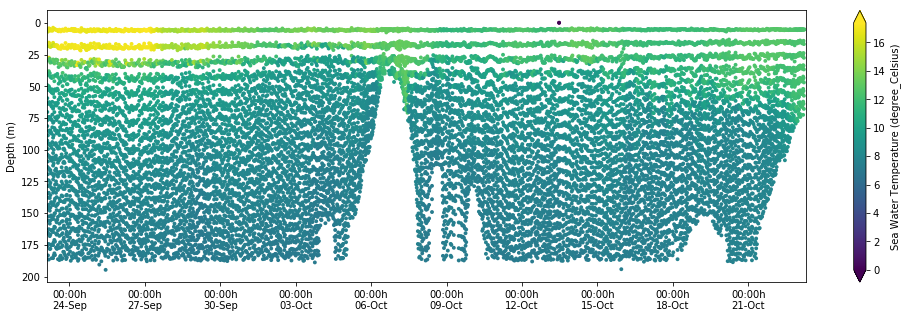

In [28]:
import matplotlib.dates as mdates


fig, ax = plt.subplots(figsize=(17, 5))
kw = dict(s=15, c=temperature_df['temperature'], marker='o', edgecolor='none')
cs = ax.scatter(temperature_df.index, temperature_df['depth'], **kw)

ax.invert_yaxis()
ax.set_xlim(temperature_df.index[0], temperature_df.index[-1])

xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('{} ({})'.format(ds.temperature.attrs['long_name'], ds.temperature.attrs['units']))
ax.set_ylabel('Depth ({})'.format(ds['depth'].attrs['units']));

One can build the proper variables programmatically, feed them in erddapy, and then build a service like [this notebook](https://mybinder.org/v2/gh/ioos/BioData-Training-Workshop/master?filepath=notebooks/ERDDAP_timeseries_explorer-IOOS.ipynb). However, erddapy is also designed for interactive work. One can explore interactively the ERDDAP server from Python.

PS: Note that in this example we did not feed any variables other than the server URL

### Plot the glider track on a simple map, for reference
We'll first convert the DataFrame to a `GeoPandas` GeoDataFrame, to take advantage of GeoPandas' convenience.

In [29]:
temperature_gdf = gpd.GeoDataFrame(temperature_df,
                                   geometry=temperature_df[['longitude', 'latitude']].apply(
                                       shpgeom.Point, axis=1))

In [30]:
world_gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

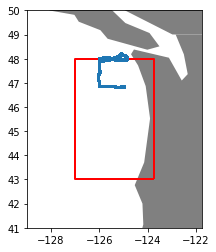

In [31]:
ax = endurance_bbox_gs.plot(ax=world_gdf.plot(facecolor='gray', figsize=(4, 4)), 
                            facecolor='none', edgecolor='red', linewidth=2)
temperature_gdf.plot(ax=ax, markersize=3)

bounds = endurance_bbox_gs.geometry.bounds
ax.set_xlim([bounds.minx[0]-2, bounds.maxx[0]+2])
ax.set_ylim([bounds.miny[0]-2, bounds.maxy[0]+2]);

## 3. Query and plot on interative Folium map all track points

### Query, download and process the glider track data

In [32]:
e = ERDDAP(server=server, protocol=protocol)

In [33]:
variables = [
 'latitude',
 'longitude',
]

constraints = {
    'time>=': min_time,
    'time<=': max_time,
}

# Spatial constraints would look like this;
#     'latitude>=': 38.0,
#     'latitude<=': 41.0,
#     'longitude>=': -72.0,
#     'longitude<=': -69.0,

In [34]:
from requests.exceptions import HTTPError

tracks_df_lst = []
for glider in gliders:
    try:
        download_url = e.get_download_url(
            protocol='tabledap',
            response='csv',
            dataset_id=glider,
            variables=variables,
            constraints=constraints
        )
        # Add a "distinct" constraint, to reduce the amount of data that's downloaded
        # (have the Glider DAC server do the work)
        download_url += '&distinct()'  # should try to url encode ...
    except HTTPError:
        continue
    
    track_df = pd.read_csv(download_url, skiprows=[1])
    track_df['glider'] = glider
    tracks_df_lst.append(track_df)

**Create a Geopandas GDF out of the data that was downloaded. A GeoDataFrame can be leveraged for more convenient exploration.**

In [35]:
tracks_df = pd.concat(tracks_df_lst)
tracks_df.dropna(axis='index', how='any', inplace=True)
#tracks_df.reset_index(inplace=True, drop=True)
tracks_gdf = gpd.GeoDataFrame(tracks_df,
                              geometry=tracks_df[['longitude', 'latitude']].apply(shpgeom.Point, axis=1))

In [36]:
tracks_gdf.head()

,latitude,longitude,glider,geometry
0,44.295774,-124.934671,ce_247-20160510T0242,POINT (-124.9346713548978 44.29577371160638)
1,44.298201,-124.939611,ce_247-20160510T0242,POINT (-124.9396114828845 44.29820079195443)
2,44.298655,-124.933415,ce_247-20160510T0242,POINT (-124.9334150703943 44.29865516378541)
3,44.300082,-124.933344,ce_247-20160510T0242,POINT (-124.9333438004509 44.30008218313972)
4,44.302146,-124.935426,ce_247-20160510T0242,POINT (-124.9354255892813 44.30214569978096)


In [37]:
tracks_gdf.glider.value_counts()

ce_383-20150813T2109    5492
ce_326-20150410T1942    5171
ce_382-20150121T2202    5077
ce_327-20150603T0000    4596
ce_247-20160928T2157    4033
ce_327-20151015T1701    2938
ce_311-20161011T2101    2657
ce_311-20160122T2045    2521
ce_326-20151015T1908    2279
ce_386-20160922T2355    2097
ce_326-20160217T1655    1870
ce_247-20160510T0242    1761
SG187-20150616T1034     1558
ce_319-20151008T2255    1432
ce_327-20160923T0147    1274
ce_386-20161215T1736    1214
ce_320-20160616T2004    1141
ce_386-20151015T2247    1129
ce_382-20160928T2102    1038
ce_312-20160920T1743     985
ce_386-20150404T1729     933
ce_384-20150411T1807     882
ce_384-20160507T1655     836
ce_383-20150121T2028     664
ce_327-20161215T2058     571
ce_312-20160122T2140     527
UW157-20141116T2118      343
ce_319-20160616T1912     327
SG187-20140625T1330      263
Name: glider, dtype: int64

In [38]:
#glider_alldup = [glider for glider in tracks_gdf.glider.unique()
#                 if glider.startswith('all')]
#glider_alldup

# tracks_gdf = tracks_gdf[~tracks_gdf.glider.isin(glider_alldup)].copy()

### Let's plot the tracks for all the gliders found in that search.

In [39]:
from palettable import cubehelix

colors = cubehelix.Cubehelix.make(
    n=len(tracks_gdf.glider.unique()), 
    start_hue=240, end_hue=-300, min_sat=1, max_sat=2.5,
    min_light=0.3, max_light=0.8, gamma=0.9
).hex_colors

In [40]:
tiles = ('http://services.arcgisonline.com/arcgis/rest/services/'
         'World_Topo_Map/MapServer/MapServer/tile/{z}/{y}/{x}')

ctr = tracks_gdf.unary_union.centroid
m = folium.Map(location=[ctr.y, ctr.x], zoom_start=6, tiles=tiles, attr='ESRI')

In [41]:
# x = tracks_gdf.geometry.iloc[0]
# x is a shapely Point
# x.coords.xy returns array('d', [-124.9346713548978]), array('d', [44.29577371160638])

# import numpy as np
# coords = np.vstack(bounds.boundary.coords.xy)
# folium.PolyLine(coords[::-1].T).add_to(m)

# type(tracks_gdf.geometry.x) is pandas.core.series.Series
# tracks_gdf.geometry.type.value_counts() is 55,620
#tracks_gdf.geometry.apply()

In [42]:
for k, glider in enumerate(tracks_gdf['glider'].unique()):
    gdf = tracks_gdf.loc[tracks_gdf['glider'] == glider]

    # Later: replace with a cleaner, faster scheme that uses geometry properites & methods
    locations = list(zip(gdf['latitude'].values, gdf['longitude'].values))

    # It's plotting lines. Better to plot points? (ie, faster, etc)
    # But not markers proper -- that'd be big clutter. Need a simple point symbol
    # ULTIMATELY, it'll be even nicer to use PySAL to calculate the mean track location!
    folium.PolyLine(
        locations=locations,
        color=colors[k],
        weight=8,
        opacity=0.7,
        tooltip=glider,
        popup=glider, # Later: add "provider" to popup text.
    ).add_to(m)

    
folium.GeoJson(endurance_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

m